In [1]:
import os
import random
import cobra.io
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns

In [2]:
# Load the model
model_dir = "yeast-GEM/model"
model_file = next(f for f in os.listdir(model_dir) if f.endswith('.xml'))  # find the first .xml file in the directory
model_path = os.path.join(model_dir, model_file)
model = cobra.io.read_sbml_model(model_path)


In [3]:

# Initialize an empty directed graph
graph = ig.Graph(directed=True)

# Exclude certain metabolites if needed
metabolites_to_exclude = []

# Add all metabolites as nodes and store names and IDs, set reversibility to None
for metabolite in model.metabolites:
    if metabolite.name not in metabolites_to_exclude:
        graph.add_vertex(name=metabolite.id, label=metabolite.name, type='metabolite', reversible=None)

# Add reactions as nodes and store names and IDs
for reaction in model.reactions:
    graph.add_vertex(name=reaction.id, label=reaction.name, type='reaction', reversible=reaction.reversibility)

# Dictionary to quickly get the vertex index from the metabolite and reaction IDs
vertex_name_to_index = {v['name']: v.index for v in graph.vs}

# Iterate over reactions in the Yeast8 metabolic model to add them as directed edges
for reaction in model.reactions:
    reaction_vertex_index = vertex_name_to_index[reaction.id]
    
    for substrate in reaction.reactants:
        if substrate.name not in metabolites_to_exclude and substrate.id in vertex_name_to_index:
            substrate_vertex_index = vertex_name_to_index[substrate.id]
            # Add a directed edge from substrate to reaction
            graph.add_edge(substrate_vertex_index, reaction_vertex_index)
            
            # If the reaction is reversible, add the reverse edge as well
            if reaction.reversibility:
                graph.add_edge(reaction_vertex_index, substrate_vertex_index)
    
    for product in reaction.products:
        if product.name not in metabolites_to_exclude and product.id in vertex_name_to_index:
            product_vertex_index = vertex_name_to_index[product.id]
            # Add a directed edge from reaction to product
            graph.add_edge(reaction_vertex_index, product_vertex_index)
            
            # If the reaction is reversible, add the reverse edge as well
            if reaction.reversibility:
                graph.add_edge(product_vertex_index, reaction_vertex_index)

In [4]:
graph.ecount() # number of edges in graph -- to be used to create randomly connected network

20772

In [5]:
# Initialize a variable to count bidirectional edges
bidirectional_edge_count = 0

# Iterate over all edges in the graph
for edge in graph.es:
    source_index = edge.source
    target_index = edge.target
    
    # Check if the source node is a metabolite and the target node is a reaction
    if graph.vs[source_index]['type'] == 'metabolite' and graph.vs[target_index]['type'] == 'reaction':
        # Check if there is an edge from the target node to the source node (bidirectional edge)
        if graph.are_connected(target_index, source_index):
            bidirectional_edge_count += 1

# Print the count of bidirectional edges
print("Number of bidirectional edges between metabolites and reactions:", bidirectional_edge_count)


Number of bidirectional edges between metabolites and reactions: 5190


In [6]:
5190/20772

0.24985557481224727

In [7]:

# Create dictionaries to quickly get the vertex index from the metabolite and reaction IDs
metabolite_to_index = {metabolite.id: index for index, metabolite in enumerate(model.metabolites)}
reaction_to_index = {reaction.id: index + len(metabolite_to_index) for index, reaction in enumerate(model.reactions)}


In [8]:
# Read in the metal annotation file (assuming it has columns 'ORF' and 'term')
metal_annotation_df = pd.read_csv("/Users/aulakhs/Documents/RalserLab/metallica/databases/metal_binding_transport_anno.csv")

# Create a mapping of ORFs to metal annotations
orf_to_term = dict(zip(metal_annotation_df['ORF'], metal_annotation_df['term']))

In [9]:
# Calculate the number of ORFs to select (17.25% of all ORFs)
all_orfs = []
for reaction in model.reactions:
    for gene in reaction.genes:
        all_orfs.append(gene.id)

orf_proportion = len(set(all_orfs) & set(orf_to_term.keys())) / len(all_orfs)
print('number of metal binding ORFs in model', len(set(all_orfs) & set(orf_to_term.keys())))
print('total number of ORFs in model', len(all_orfs))
print('fraction of ORFs that are metal binding', orf_proportion)
num_orfs_to_select = len(set(all_orfs) & set(orf_to_term.keys()))

number of metal binding ORFs in model 299
total number of ORFs in model 4105
fraction of ORFs that are metal binding 0.0728380024360536


In [10]:
# Centrality metrics to be calculated
centrality_measures = {
    'degree': lambda: graph.degree(mode='all'),
    'in_degree': lambda: graph.degree(mode='in'),
    'out_degree': lambda: graph.degree(mode='out'),
    'betweenness': lambda: graph.betweenness(directed=True),
    'closeness': lambda: graph.closeness(),
    'eigenvector': lambda: graph.eigenvector_centrality(directed=True),
    'pagerank': lambda: graph.pagerank(directed=True),
    'authority_score': lambda: graph.authority_score(),
    'hub_score': lambda: graph.hub_score(),
}
# Calculate centrality metrics for all nodes and store them
centrality_metrics_all_nodes = {measure: measure_func() for measure, measure_func in centrality_measures.items()}


In [11]:
# Function to fetch centrality measures for selected ORFs
def fetch_centrality_metrics(centrality_metrics_all_nodes, selected_orfs):
    results = {measure: [] for measure in centrality_measures}
    for measure_name in centrality_measures:
        centrality_values = centrality_metrics_all_nodes[measure_name]
        selected_reaction_indices = [
            vertex_name_to_index[reaction.id] for reaction in model.reactions
            if any(gene.id in selected_orfs for gene in reaction.genes)
        ]
        selected_centrality_values = [centrality_values[i] for i in selected_reaction_indices]
        results[measure_name] = selected_centrality_values
    return results

In [12]:
# random ORF metrics
n_iterations = 1000
random_results = {measure: [] for measure in centrality_measures}

for _ in range(n_iterations):
    selected_orfs = random.sample(all_orfs, num_orfs_to_select)
    iteration_results = fetch_centrality_metrics(centrality_metrics_all_nodes, selected_orfs)
    for measure in centrality_measures:
        random_results[measure].extend(iteration_results[measure])
            

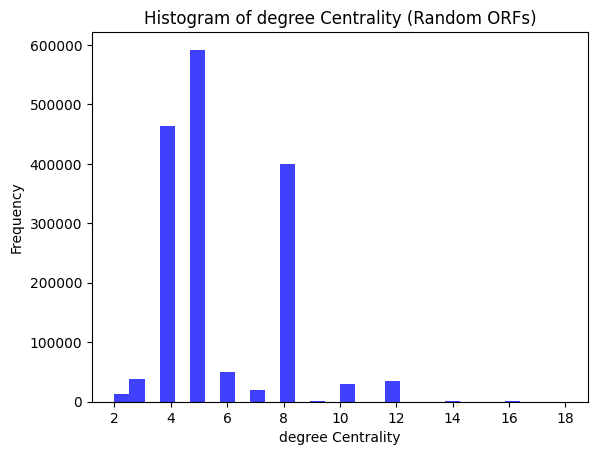

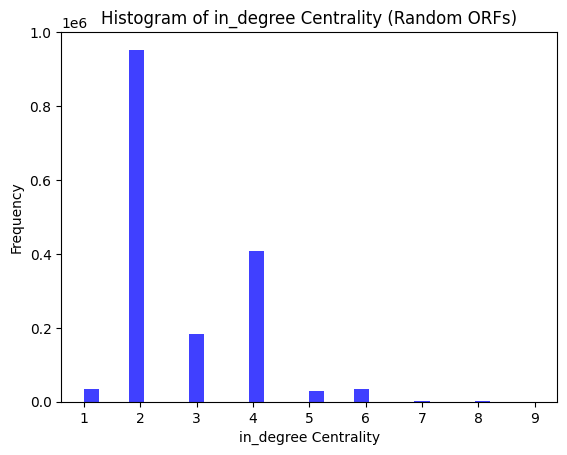

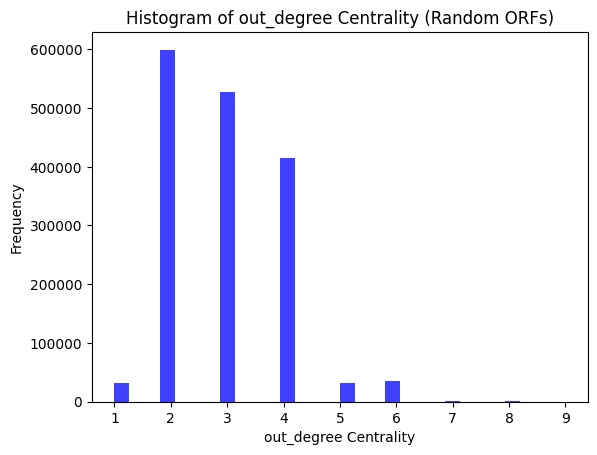

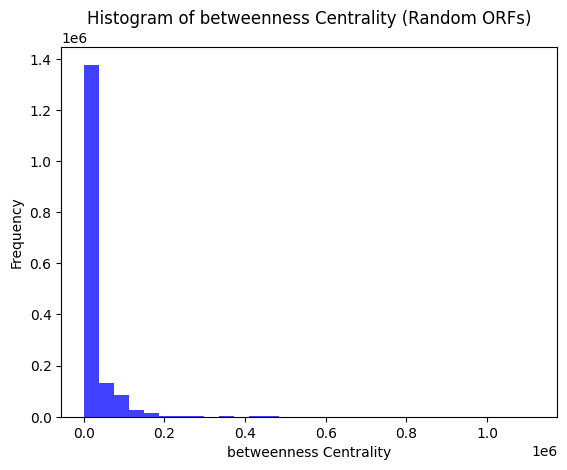

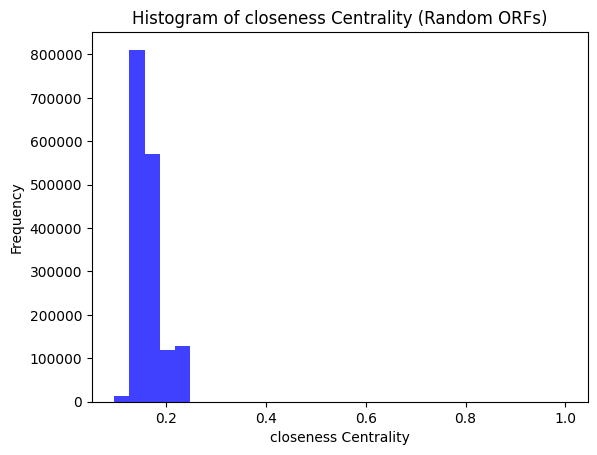

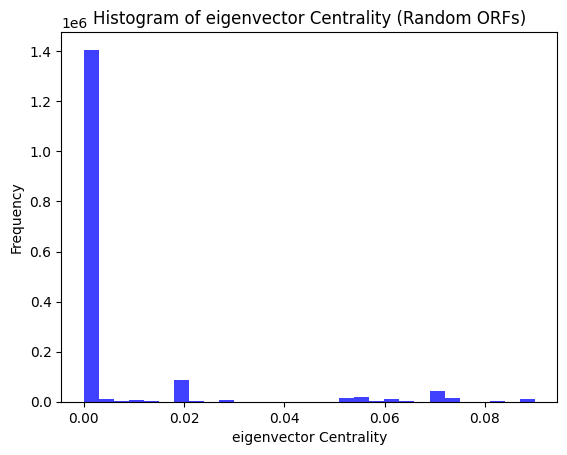

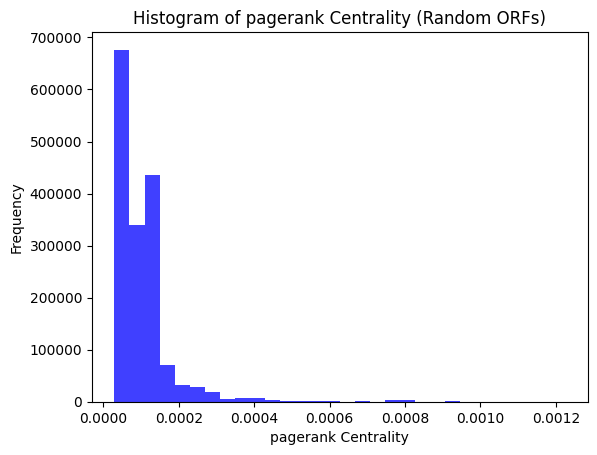

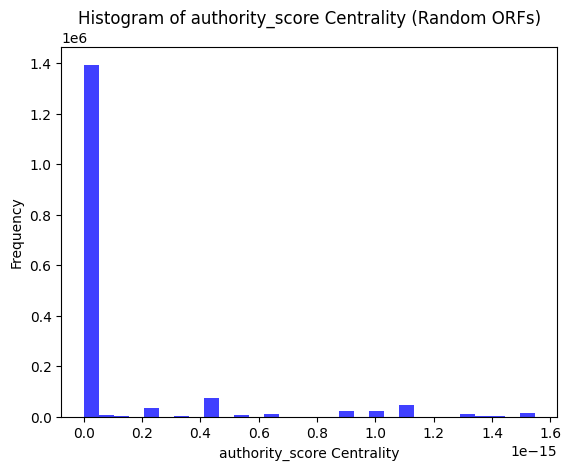

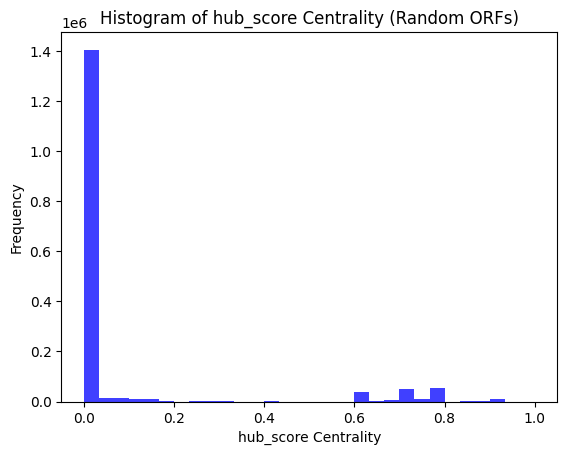

In [13]:
# Plot histograms for each centrality metric from random results
for measure, values in random_results.items():
    # Flatten the list of lists
    flattened_values = [value for value in values]
    plt.hist(flattened_values, bins=30, alpha=0.75, color='blue')
    plt.title(f'Histogram of {measure} Centrality (Random ORFs)')
    plt.xlabel(f'{measure} Centrality')
    plt.ylabel('Frequency')
    plt.show()


### Input metal anno

In [14]:
# Select ORFs that are in the metal annotation dictionary
metal_annotated_orfs = set(orf_to_term.keys())

# Calculate centrality metrics for metal-annotated ORFs
metal_results = fetch_centrality_metrics(centrality_metrics_all_nodes, metal_annotated_orfs)


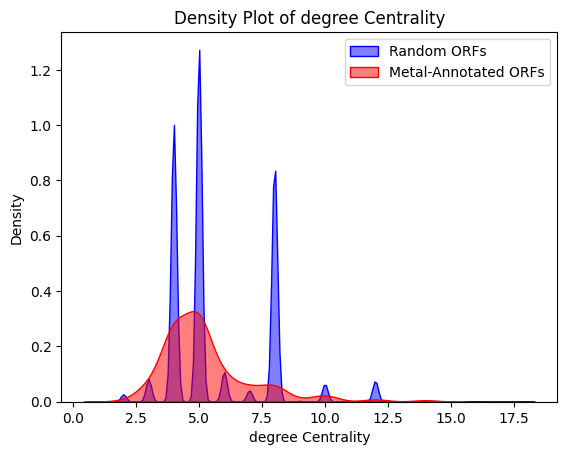

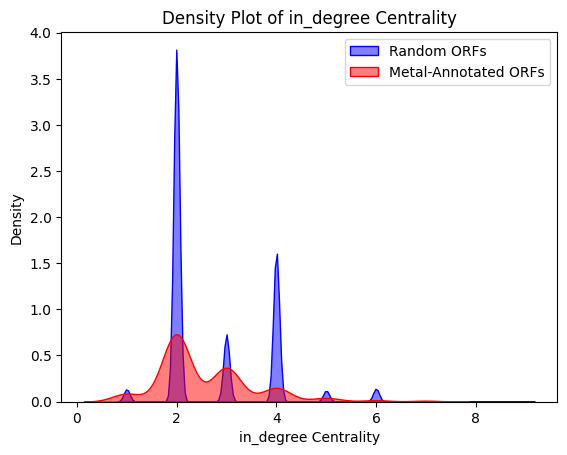

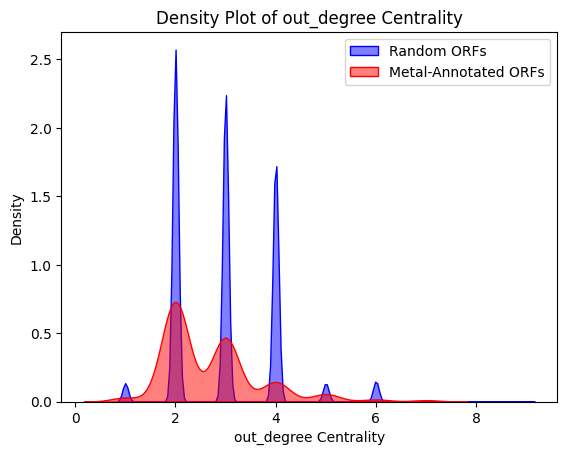

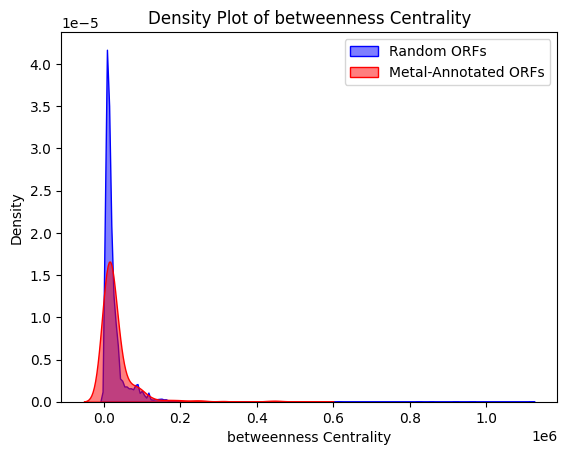

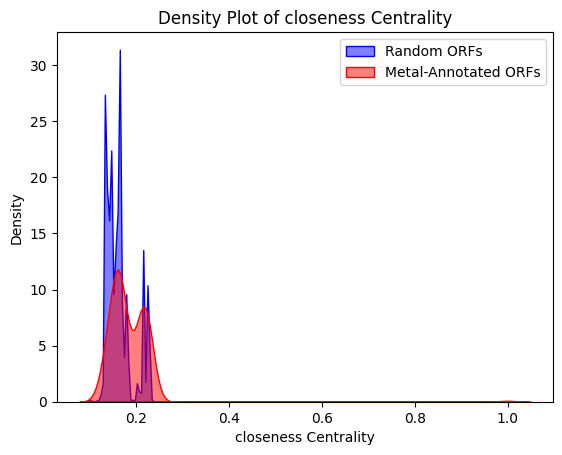

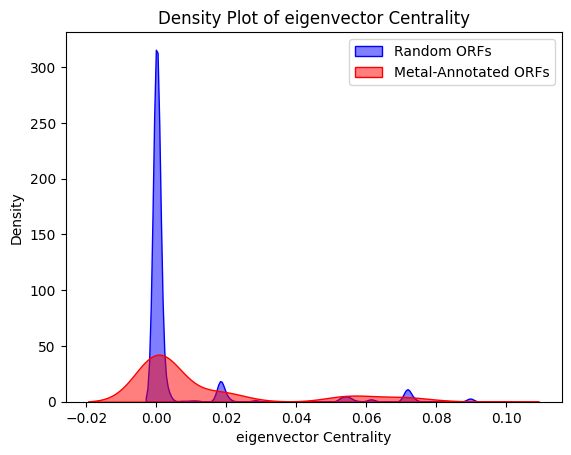

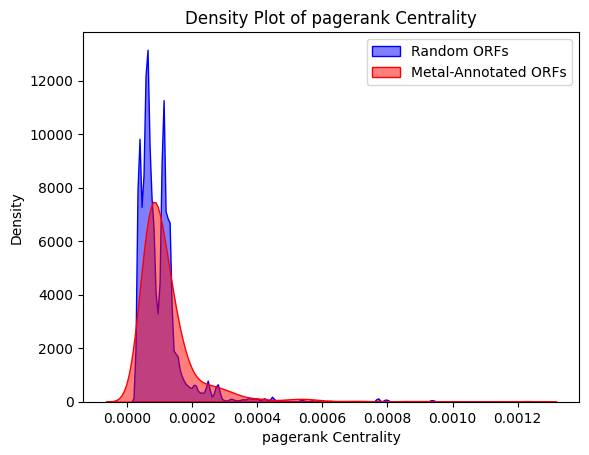

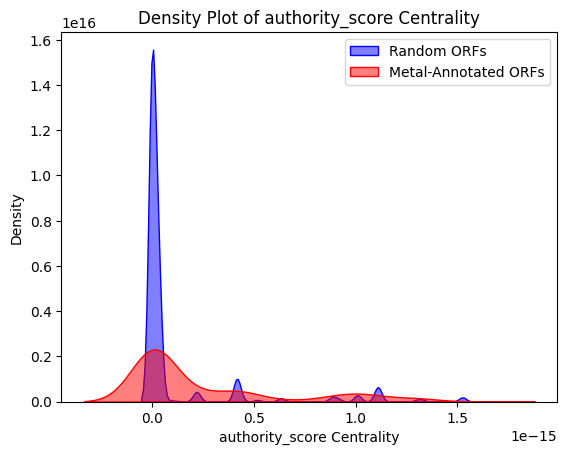

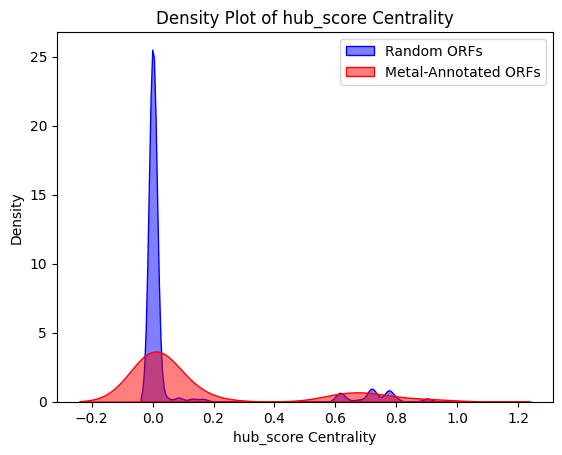

In [15]:
# Plot histograms and density plots for each centrality metric for metal-annotated ORFs and random ORFs
for measure in centrality_measures:
    # Get the centrality values for the random ORFs from all iterations
    random_values = random_results[measure]
    
    # Get the centrality values for the metal-annotated ORFs
    metal_values = metal_results[measure]

    # Plot density plots
    sns.kdeplot(random_values, fill=True, color='blue', alpha=0.5, label='Random ORFs')
    sns.kdeplot(metal_values, fill=True, color='red', alpha=0.5, label='Metal-Annotated ORFs')
    plt.title(f'Density Plot of {measure} Centrality')
    plt.xlabel(f'{measure} Centrality')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Stats tests

In [16]:
from scipy.stats import mannwhitneyu, rankdata

# Function to calculate the effect size for the Mann-Whitney U test
def mannwhitneyu_effect_size(U, n1, n2):
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (U - mean_U) / std_U
    effect_size = z / np.sqrt(n1 + n2)
    return effect_size

# Initialize a dictionary to store p-values, medians, and effect sizes
stats_results = {measure: {} for measure in centrality_measures}

# Perform statistical tests for each centrality metric
for measure in centrality_measures:
    # Get the centrality values for the random ORFs from all iterations
    random_values = random_results[measure]
    
    # Get the centrality values for the metal-annotated ORFs
    metal_values = metal_results[measure]
    
    # Perform the Mann-Whitney U test with metal_values as the first argument
    U, p_value = mannwhitneyu(metal_values, random_values, alternative='two-sided')
    stats_results[measure]['p_value'] = p_value
    
    # Calculate medians
    random_median = np.median(random_values)
    metal_median = np.median(metal_values)
    random_mean = np.mean(random_values)
    metal_mean = np.mean(metal_values)
    stats_results[measure]['random_median'] = random_median
    stats_results[measure]['metal_median'] = metal_median
    stats_results[measure]['random_mean'] = random_mean
    stats_results[measure]['metal_mean'] = metal_mean

    # Calculate effect size for the Mann-Whitney U test
    n1 = len(metal_values)
    n2 = len(random_values)
    effect_size = mannwhitneyu_effect_size(U, n1, n2)
    stats_results[measure]['effect_size'] = effect_size

# Print the p-values, median comparisons, and effect sizes
print("P-values, Median Comparisons, and Effect Sizes for each centrality measure:")
for measure, results in stats_results.items():
    print(f'{measure} Centrality:')
    print(f'  p-value: {results["p_value"]:.4f}')
    print(f'  Random ORFs median: {results["random_median"]}')
    print(f'  Metal-Annotated ORFs median: {results["metal_median"]}')
    print(f'  Effect size (Mann-Whitney U): {results["effect_size"]:.4f}')
    
    if results["metal_median"] > results["random_median"]:
        print(f'  Metal-Annotated ORFs have higher {measure} Centrality based on median\n')
    elif results["metal_median"] < results["random_median"]:
        print(f'  Random ORFs have higher {measure} Centrality based on median\n')
    else:
        print(f'  Medians are equal for {measure} Centrality\n')

    if results["effect_size"] > 0:
        print(f'  Metal-Annotated ORFs have higher {measure} Centrality based on effect size\n')
    elif results["effect_size"] < 0:
        print(f'  Random ORFs have higher {measure} Centrality based on effect size\n')
    else:
        print(f'  Effect size indicates no difference for {measure} Centrality\n')


P-values, Median Comparisons, and Effect Sizes for each centrality measure:
degree Centrality:
  p-value: 0.0000
  Random ORFs median: 5.0
  Metal-Annotated ORFs median: 5.0
  Effect size (Mann-Whitney U): -0.0038
  Medians are equal for degree Centrality

  Random ORFs have higher degree Centrality based on effect size

in_degree Centrality:
  p-value: 0.0056
  Random ORFs median: 2.0
  Metal-Annotated ORFs median: 2.0
  Effect size (Mann-Whitney U): -0.0019
  Medians are equal for in_degree Centrality

  Random ORFs have higher in_degree Centrality based on effect size

out_degree Centrality:
  p-value: 0.0000
  Random ORFs median: 3.0
  Metal-Annotated ORFs median: 2.0
  Effect size (Mann-Whitney U): -0.0055
  Random ORFs have higher out_degree Centrality based on median

  Random ORFs have higher out_degree Centrality based on effect size

betweenness Centrality:
  p-value: 0.0001
  Random ORFs median: 15270.371183187071
  Metal-Annotated ORFs median: 17208.405523947953
  Effect si

In [17]:
from scipy.stats import mannwhitneyu, rankdata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate the effect size for the Mann-Whitney U test
def mannwhitneyu_effect_size(U, n1, n2):
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (U - mean_U) / std_U
    effect_size = z / np.sqrt(n1 + n2)
    return effect_size

# Initialize a dictionary to store p-values, medians, means, and effect sizes
stats_results = {measure: {} for measure in centrality_measures}

# Perform statistical tests for each centrality metric
for measure in centrality_measures:
    # Get the centrality values for the random ORFs from all iterations
    random_values = random_results[measure]
    
    # Get the centrality values for the metal-annotated ORFs
    metal_values = metal_results[measure]
    
    # Perform the Mann-Whitney U test with metal_values as the first argument
    U, p_value = mannwhitneyu(metal_values, random_values, alternative='two-sided')
    stats_results[measure]['p_value'] = p_value
    
    # Calculate medians and means
    random_median = np.median(random_values)
    metal_median = np.median(metal_values)
    random_mean = np.mean(random_values)
    metal_mean = np.mean(metal_values)
    stats_results[measure]['random_median'] = random_median
    stats_results[measure]['metal_median'] = metal_median
    stats_results[measure]['random_mean'] = random_mean
    stats_results[measure]['metal_mean'] = metal_mean

    # Calculate effect size for the Mann-Whitney U test
    n1 = len(metal_values)
    n2 = len(random_values)
    effect_size = mannwhitneyu_effect_size(U, n1, n2)
    stats_results[measure]['effect_size'] = effect_size

# Prepare data for DataFrame
data = {
    'Centrality Measure': list(stats_results.keys()),
    'p-value': [stats_results[measure]['p_value'] for measure in stats_results.keys()],
    'Effect Size': [stats_results[measure]['effect_size'] for measure in stats_results.keys()],
    'Random Median': [stats_results[measure]['random_median'] for measure in stats_results.keys()],
    'Metal Median': [stats_results[measure]['metal_median'] for measure in stats_results.keys()],
    'Random Mean': [stats_results[measure]['random_mean'] for measure in stats_results.keys()],
    'Metal Mean': [stats_results[measure]['metal_mean'] for measure in stats_results.keys()]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
results_df.to_csv('random_vs_metal_centrality_metrics_statresults.csv', index=False)

# Display the DataFrame
print(results_df)


  Centrality Measure       p-value  Effect Size  Random Median  Metal Median  \
0             degree  5.036770e-07    -0.003753   5.000000e+00  5.000000e+00   
1          in_degree  5.572556e-03    -0.001920   2.000000e+00  2.000000e+00   
2         out_degree  1.425604e-13    -0.005479   3.000000e+00  2.000000e+00   
3        betweenness  7.386042e-05     0.003093   1.527037e+04  1.720841e+04   
4          closeness  5.985927e-47     0.011229   1.562076e-01  1.698396e-01   
5        eigenvector  4.724215e-70     0.013807   5.053255e-05  3.186183e-04   
6           pagerank  6.944246e-16     0.006299   8.056803e-05  9.801864e-05   
7    authority_score  2.561536e-24     0.007515   9.149485e-19  2.241624e-17   
8          hub_score  7.349893e-51     0.011702   3.094635e-05  3.321850e-03   

    Random Mean    Metal Mean  
0  5.686528e+00  5.271583e+00  
1  2.731124e+00  2.579137e+00  
2  2.955405e+00  2.692446e+00  
3  2.736234e+04  3.528369e+04  
4  1.622003e-01  1.835180e-01  
5  6.10

In [18]:

# Extract the data for plotting
measures = list(stats_results.keys())
p_values = [stats_results[measure]['p_value'] for measure in measures]
effect_sizes = [stats_results[measure]['effect_size'] for measure in measures]
random_medians = [stats_results[measure]['random_median'] for measure in measures]
metal_medians = [stats_results[measure]['metal_median'] for measure in measures]
random_means = [stats_results[measure]['random_mean'] for measure in measures]
metal_means = [stats_results[measure]['metal_mean'] for measure in measures]

# Convert p-values to a logarithmic scale for better visualization
log_p_values = [-np.log10(p) if p > 0 else 0 for p in p_values]


In [19]:

from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file to save all plots
pdf_pages = PdfPages('random_vs_metal_centrality_statresults_plots.pdf')

# Plot the p-values
plt.figure(figsize=(12, 6))
plt.bar(measures, log_p_values, color='skyblue', width=0.5)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.xlabel('Centrality Measure')
plt.ylabel('-log10(p-value)')
plt.title('Mann-Whitney U Test Results')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
pdf_pages.savefig()
plt.close()

# Plot the effect sizes with labels
plt.figure(figsize=(12, 6))
bars = plt.bar(measures, effect_sizes, color='lightgreen', width=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Centrality Measure')
plt.ylabel('Effect Size (Mann-Whitney U)')
plt.title('Effect Sizes for Centrality Measures')
plt.xticks(rotation=45)
plt.text(len(measures) - 0.5, max(effect_sizes) * 0.02, 'Metal-Annotated ORFs higher', color='green', ha='center', va='bottom', fontsize=12)
plt.text(len(measures) - 0.5, min(effect_sizes) * 0.02, 'Random ORFs higher', color='green', ha='center', va='top', fontsize=12)
plt.tight_layout()
pdf_pages.savefig()
plt.close()

# Plot the medians and means in separate panels for each centrality measure
for measure, random_median, metal_median, random_mean, metal_mean in zip(measures, random_medians, metal_medians, random_means, metal_means):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot medians
    ax[0].bar(['Random', 'Metal'], [random_median, metal_median], color=['orange', 'blue'], width=0.5)
    ax[0].set_title(f'{measure} Median')
    ax[0].set_ylabel('Median Value')
    
    # Plot means
    ax[1].bar(['Random', 'Metal'], [random_mean, metal_mean], color=['orange', 'blue'], width=0.5)
    ax[1].set_title(f'{measure} Mean')
    ax[1].set_ylabel('Mean Value')
    
    fig.suptitle(f'{measure} Centrality Measures')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure to the PDF file
    pdf_pages.savefig()
    plt.close()  # Close the figure to avoid displaying it
    
# Close the PDF file
pdf_pages.close()

print("All plots saved in a single PDF.")


All plots saved in a single PDF.


# Distances between metal nodes

In [20]:
## define function to calculate shortest distance 
def compute_shortest_distances(graph, source_nodes, target_nodes):
    """
    Compute the shortest distance from each source node to any of the target nodes.

    Parameters:
    - graph: the graph in which to calculate distances.
    - source_nodes: a list of nodes for which to calculate the shortest distances.
    - target_nodes: a list of target nodes to which the shortest distances are to be calculated.

    Returns:
    A dictionary where keys are the target nodes and values are their respective shortest distances to any of the target nodes.
    """
    
    shortest_distances_to_target = {}

    for target in target_nodes:
        shortest_distance = float('inf')
        for source in source_nodes:
            try:
                path_length = graph.distances(source=source, target=target)[0][0]
                if path_length < shortest_distance:
                    shortest_distance = path_length
            except:
                # In case there is no path between nodes, igraph raises an exception
                continue
        shortest_distances_to_target[target] = shortest_distance

    return shortest_distances_to_target

from collections import Counter

def compute_statistics(distance_list):
    total_count = len(distance_list)
    distance_counts = Counter(distance_list)
    
    # Calculate statistics for each group
    statistics = {}
    for distance, count in distance_counts.items():
        percentage = (count / total_count) * 100
        statistics[distance] = {
            "count": count,
            "total": total_count,
            "percentage": percentage
        }

    return statistics



## Iterate 100 times to pick nodes randomly as metal annotated and calculate distances from all other nodes to the randomly annotated metal nodes

In [ ]:
n_iterations = 1000
results_list = []

for iteration in range(n_iterations):
    # Randomly select num_orfs_to_select ORFs from all_orfs
    selected_orfs = random.sample(all_orfs, num_orfs_to_select)
    
    # Find reactions associated with the selected ORFs
    selected_reaction_ids = set()
    for reaction in model.reactions:
        for gene in reaction.genes:
            if gene.id in selected_orfs:
                selected_reaction_ids.add(reaction.id)
    
    # Map reaction IDs to vertex indices in the graph
    random_metal_node_indices = [
        vertex_name_to_index[rxn_id]
        for rxn_id in selected_reaction_ids
        if rxn_id in vertex_name_to_index
    ]
    
    # Get all reaction node indices
    all_reaction_node_indices = [
        v.index
        for v in graph.vs
        if v['type'] == 'reaction'
    ]
    
    # Get all metabolite node indices
    all_metabolite_node_indices = [
        v.index
        for v in graph.vs
        if v['type'] == 'metabolite'
    ]
    
    # Compute shortest distances to other reaction nodes
    distances_reaction = compute_shortest_distances(
        graph, random_metal_node_indices, all_reaction_node_indices
    )
    distances_reaction_list = list(distances_reaction.values())
    stats_reaction = compute_statistics(distances_reaction_list)
    
    # Compute shortest distances to metabolite nodes
    distances_metabolite = compute_shortest_distances(
        graph, random_metal_node_indices, all_metabolite_node_indices
    )
    distances_metabolite_list = list(distances_metabolite.values())
    stats_metabolite = compute_statistics(distances_metabolite_list)
    
    # Collect results for reactions
    for distance, stat in stats_reaction.items():
        results_list.append({
            'iteration': iteration,
            'distance': distance,
            'percentage': stat['percentage'],
            'node_type': 'reaction'
        })
    
    # Collect results for metabolites
    for distance, stat in stats_metabolite.items():
        results_list.append({
            'iteration': iteration,
            'distance': distance,
            'percentage': stat['percentage'],
            'node_type': 'metabolite'
        })

# Convert the list of results to a DataFrame
random_results_shortest_distances = pd.DataFrame(results_list)


In [ ]:
random_results_shortest_distances.to_csv("randomly_selected_metal_nodes_distances_1000iters.csv")

In [ ]:
random_results_shortest_distances